# EDA
The goal of this notebook is to:
- [Remove null values and validate data](#remove_null)
- [Transform data into a usable state for modelling](#transform_model)
- Perform data analysis to uncover patterns
- Eliminate any sources of data leakage

## 0. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import requests
from bs4 import BeautifulSoup
import re

from sklearn import preprocessing

<a id='remove_null'></a>
## 1. Removing Nulls & Validating Data

In [2]:
df = pd.read_csv("./data/pokedex_raw.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1028 entries, 0 to 1027
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pokedex_number    1028 non-null   int64  
 1   name              1028 non-null   object 
 2   german_name       938 non-null    object 
 3   japanese_name     938 non-null    object 
 4   generation        1028 non-null   int64  
 5   status            1028 non-null   object 
 6   species           1028 non-null   object 
 7   type_number       1028 non-null   int64  
 8   type_1            1028 non-null   object 
 9   type_2            542 non-null    object 
 10  height_m          1028 non-null   float64
 11  weight_kg         1027 non-null   float64
 12  abilities_number  1028 non-null   int64  
 13  ability_1         1025 non-null   object 
 14  ability_2         513 non-null    object 
 15  ability_hidden    810 non-null    object 
 16  total_points      1028 non-null   float64


### Dropping Unnecessary Columns

In [3]:
df.drop(["german_name", "japanese_name"], axis=1, inplace=True)

### Base Friendship,  Base Experience, Catch Rate, Percentage Male
base_friendship, base_experience, catch_rate, and percentage_male have the same number of null values. Let's investigate.

In [4]:
df.loc[df["base_friendship"].isnull() & df["base_experience"].isnull() & df["catch_rate"].isnull() & df["percentage_male"].isnull(), ["name", "generation", "status", "base_friendship", "base_experience", "catch_rate", "percentage_male"]]

,name,generation,status,base_friendship,base_experience,catch_rate,percentage_male
69,Galarian Meowth,1,Normal,NaN,NaN,NaN,NaN
100,Galarian Ponyta,1,Normal,NaN,NaN,NaN,NaN
102,Galarian Rapidash,1,Normal,NaN,NaN,NaN,NaN
109,Galarian Farfetch'd,1,Normal,NaN,NaN,NaN,NaN
142,Galarian Weezing,1,Normal,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1023,Zacian Hero of Many Battles,8,Legendary,NaN,NaN,NaN,NaN
1024,Zamazenta Crowned Shield,8,Legendary,NaN,NaN,NaN,NaN
1025,Zamazenta Hero of Many Battles,8,Legendary,NaN,NaN,NaN,NaN
1026,Eternatus,8,Legendary,NaN,NaN,NaN,NaN


A lot of the nulls seem to be either from "Galarian" forms, or from generation 8. We can also see that the four fields are null in the same rows.

In [5]:
df.loc[df["base_friendship"].isnull() & (df["generation"] != 8)].loc[:, ["name", "pokedex_number", "generation", "status"]]

,name,pokedex_number,generation,status
69,Galarian Meowth,52,1,Normal
100,Galarian Ponyta,77,1,Normal
102,Galarian Rapidash,78,1,Normal
109,Galarian Farfetch'd,83,1,Normal
142,Galarian Weezing,110,1,Normal
156,Galarian Mr. Mime,122,1,Normal
267,Galarian Corsola,222,2,Normal
314,Galarian Zigzagoon,263,3,Normal
316,Galarian Linoone,264,3,Normal
648,Galarian Darumaka,554,5,Normal


In [6]:
df[df["generation"] == 8].isnull().sum()

pokedex_number       0
name                 0
generation           0
status               0
species              0
type_number          0
type_1               0
type_2              48
height_m             0
weight_kg            1
abilities_number     0
ability_1            1
ability_2           42
ability_hidden      13
total_points         0
hp                   0
attack               0
defense              0
sp_attack            0
sp_defense           0
speed                0
catch_rate          88
base_friendship     88
base_experience     88
growth_rate          0
egg_type_number      0
egg_type_1           0
egg_type_2          47
percentage_male     88
egg_cycles           0
against_normal       0
against_fire         0
against_water        0
against_electric     0
against_grass        0
against_ice          0
against_fight        0
against_poison       0
against_ground       0
against_flying       0
against_psychic      0
against_bug          0
against_rock         0
against_gho

### Filling Gen 8 Nulls
We need percentage_male, catch_rate, base_friendship, base_experience. We use webscraping with BeautifulSoup and bulbapedia.bulbagarden.net.

In [7]:
soup = BeautifulSoup(requests.get("https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_effort_value_yield").content, "html.parser")
expTable = soup.find_all("tr")
def getBaseExp(pNum, tablerow):
    for row in tablerow[1:]:
        if int(re.search("[0-9]+", str(row.findChildren("td")[0])).group()) == pNum:
            return int(re.search("[0-9]+", str(row.findChildren("td")[3])).group())
for pNum in df.loc[df["generation"] == 8, "pokedex_number"]:
    df.loc[df["pokedex_number"] == pNum, "base_experience"] = getBaseExp(pNum, expTable)

In [8]:
soup = BeautifulSoup(requests.get("https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_base_friendship").content, "html.parser")
friendTable = soup.find_all("tr")
def getBaseFriendship(pNum, tablerow):
    for row in tablerow[2:]:
        if int(re.search("[0-9]+", str(row.findChildren("td")[0])).group()) == pNum:
            return int(re.search("[0-9]+", str(row.findChildren("td")[4])).group())
for pNum in df["pokedex_number"]:
    df.loc[df["pokedex_number"] == pNum, "base_friendship"] = getBaseFriendship(pNum, friendTable)

In [9]:
soup = BeautifulSoup(requests.get("https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_catch_rate").content, "html.parser")
catchTable = soup.find_all("tr")
def getCatchRate(pNum, tablerow):
    for row in tablerow[2:]:
        if int(re.search("[0-9]+", str(row.findChildren("th")[0])).group()) == pNum:
            return int(re.search("[0-9]+", str(row.findChildren("td")[2])).group())
for pNum in df.loc[df["generation"] == 8, "pokedex_number"]:
    df.loc[df["pokedex_number"] == pNum, "catch_rate"] = getCatchRate(pNum, catchTable)

In [10]:
soup = BeautifulSoup(requests.get("https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_gender_ratio").content, "html.parser")
genderTable = soup.find_all("table", {"class": "sortable"})
def getPercentageMale(pNum, table):
    for i in range(len(table)):
        rows = table[i].findChildren("tr")[1:]
        for row in rows:
            if int(re.search("[0-9]+", str(row.findChildren("td")[0])).group()) == pNum:
                if 0 <= i < 2: return 100.
                elif 2 <= i < 4: return 87.5
                elif 4 <= i < 6: return 75.
                elif 6 <= i < 8: return 50.
                elif 8 <= i < 10: return 25.
                elif 10 <= i < 11: return 12.5
                elif 11 <= i < 13: return 0.
                else: return np.nan
for pNum in df.loc[df["generation"] == 8, "pokedex_number"]:
    df.loc[df["pokedex_number"] == pNum, "percentage_male"] = getPercentageMale(pNum, genderTable)

### Meltan, Melmetal, and Galarians
In addition to the Galarian forms, there are still 2 null rows for the four fields above, and they correspond to meltan and melmetal (pokedex numbers 808, 809).

In [11]:
for pNum in range(808, 810):
    df.loc[df["pokedex_number"] == pNum, "percentage_male"] = getPercentageMale(pNum, genderTable)
    df.loc[df["pokedex_number"] == pNum, "catch_rate"] = getCatchRate(pNum, catchTable)
    df.loc[df["pokedex_number"] == pNum, "base_friendship"] = getBaseFriendship(pNum, friendTable)
    df.loc[df["pokedex_number"] == pNum, "base_experience"] = getBaseExp(pNum, expTable)
for pNum in df[df["name"].str.contains("Galarian")]["pokedex_number"]:
    df.loc[df["pokedex_number"] == pNum, "percentage_male"] = getPercentageMale(pNum, genderTable)
    df.loc[df["pokedex_number"] == pNum, "catch_rate"] = getCatchRate(pNum, catchTable)
    df.loc[df["pokedex_number"] == pNum, "base_friendship"] = getBaseFriendship(pNum, friendTable)
    df.loc[df["pokedex_number"] == pNum, "base_experience"] = getBaseExp(pNum, expTable)


### Percentage Male
A large number of percentage_male is null, but null is an acceptable field (genderless). We check the validity of the original data by comparing it to our calculated results for the entire dataset.

In [12]:
maleTester = pd.DataFrame(df["pokedex_number"])
maleTester["calculated_percentage_male"] = df.apply(lambda row: getPercentageMale(row["pokedex_number"], genderTable), axis=1)
df[df["percentage_male"] != maleTester["calculated_percentage_male"]]

print(len(df[df["percentage_male"].isnull() ^ maleTester["calculated_percentage_male"].isnull()]))

0


### Weight
We see one missing value for weight.

In [13]:
df.loc[df["weight_kg"].isnull()]

,pokedex_number,name,generation,status,species,type_number,type_1,type_2,height_m,weight_kg,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
1027,890,Eternatus Eternamax,8,Legendary,Gigantic Pokémon,2,Poison,Dragon,100.0,NaN,...,2.0,1.0,2.0,0.5,1.0,1.0,2.0,1.0,1.0,1.0


A quick manual search shows that Eternatus Eternamax is a pokemon so large, it has no known weight, so we set it to an arbitrarily large value for now. 

In [14]:
df.loc[df["weight_kg"].isnull(), "weight_kg"] = df["weight_kg"].max() * 3

### Ability 1
There are 3 missing values for ability 1. 

In [15]:
df.loc[df["ability_1"].isnull(), ["name", "pokedex_number", "abilities_number", "ability_1", "ability_2", "ability_hidden"]]

,name,pokedex_number,abilities_number,ability_1,ability_2,ability_hidden
33,Partner Pikachu,25,1,NaN,NaN,Lightning Rod
170,Partner Eevee,133,1,NaN,NaN,Anticipation
1027,Eternatus Eternamax,890,0,NaN,NaN,NaN


We leave these pokemon in for completeness. 

As for Eternatus Eternamax, we fill its null values with its base form, Eternatus.

In [16]:
df[df["name"] == "Eternatus Eternamax"].isnull().any() & ~df[df["name"] == "Eternatus"].isnull().any()

pokedex_number      False
name                False
generation          False
status              False
species             False
type_number         False
type_1              False
type_2              False
height_m            False
weight_kg           False
abilities_number    False
ability_1            True
ability_2           False
ability_hidden      False
total_points        False
hp                  False
attack              False
defense             False
sp_attack           False
sp_defense          False
speed               False
catch_rate          False
base_friendship     False
base_experience     False
growth_rate         False
egg_type_number     False
egg_type_1          False
egg_type_2          False
percentage_male     False
egg_cycles          False
against_normal      False
against_fire        False
against_water       False
against_electric    False
against_grass       False
against_ice         False
against_fight       False
against_poison      False
against_grou

In [17]:
df.loc[df["name"] == "Eternatus Eternamax", "ability_1"] = df[df["name"] == "Eternatus"]["ability_1"].values

### Egg Cycles and Growth Rate

In [18]:
df[df["egg_cycles"].isnull() & df["growth_rate"].isnull()]

,pokedex_number,name,generation,status,species,type_number,type_1,type_2,height_m,weight_kg,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
652,555,Darmanitan Galarian Zen Mode,5,Normal,Zen Charm Pokémon,2,Ice,Fire,1.7,120.0,...,2.0,1.0,1.0,0.5,4.0,1.0,1.0,1.0,1.0,0.5


We fill this pokemon's null fields with its non-Galarian version.

In [19]:
df.loc[df["name"] == "Darmanitan Galarian Zen Mode", "egg_cycles"] = df[df["name"] == "Darmanitan Zen Mode"]["egg_cycles"].values
df.loc[df["name"] == "Darmanitan Galarian Zen Mode", "growth_rate"] = df[df["name"] == "Darmanitan Zen Mode"]["growth_rate"].values
df.loc[df["name"] == "Darmanitan Galarian Zen Mode", "egg_type_1"] = df[df["name"] == "Darmanitan Zen Mode"]["egg_type_1"].values

### Type Number, Ability Number, and Egg Type Number

We note that there are two inconsistencies with these fields, where the ability or egg type number is 0, but the pokemon does have an ability or egg type, respectively.

In [20]:
df.loc[(df['abilities_number'] == 0) & ~df['ability_1'].isnull(), ['name', 'abilities_number', 'ability_1', 'ability_2', 'ability_hidden']]

,name,abilities_number,ability_1,ability_2,ability_hidden
1027,Eternatus Eternamax,0,Pressure,NaN,NaN


In [21]:
df.loc[(df['egg_type_number'] == 0) & ~df['egg_type_1'].isnull(), ['name', 'egg_type_number', 'egg_type_1', 'egg_type_2']]

,name,egg_type_number,egg_type_1,egg_type_2
652,Darmanitan Galarian Zen Mode,0,Field,NaN


We set these values to 1.

In [22]:
df.loc[df["name"] == "Eternatus Eternamax", "abilities_number"] = 1
df.loc[df["name"] == "Darmanitan Galarian Zen Mode", "egg_type_number"] = 1

We then verify that the remaining data is valid.

In [23]:
print(len(df[(df['type_number'] == 0) & ~df['type_1'].isnull()]))
print(len(df[(df['type_number'] == 1) & ~df['type_2'].isnull()]))
print(len(df[(df['type_number'] == 2) & df['type_2'].isnull()]))

print(len(df[df['abilities_number'] == 0] & ~df['ability_1'].isnull()))
print(len(df[(df['abilities_number'] == 1) & ~(df['ability_2'].isnull() | df['ability_hidden'].isnull())]))
print(len(df[(df['abilities_number'] == 2) & (df['ability_2'].isnull() & df['ability_hidden'].isnull())]))
print(len(df[(df['abilities_number'] == 3) & (df['ability_2'].isnull() | df['ability_hidden'].isnull())]))

print(len(df[(df['egg_type_number'] == 0) & ~df['egg_type_1'].isnull()]))
print(len(df[(df['egg_type_number'] == 1) & ~df['egg_type_2'].isnull()]))
print(len(df[(df['egg_type_number'] == 2) & df['egg_type_2'].isnull()]))

0
0
0
0
0
0
0
0
0
0


### Saving Version

In [24]:
df.to_csv("./data/pokedex_clean.csv")

<a id='transform_model'></a>
## 2. Transform Data for Modelling

All the invalid/incomplete data has been filled. This section will replace remaining valid null values with a more appropriate number or by encoding it with a one-hot tensor, for example.

In [25]:
df = pd.read_csv("./data/pokedex_clean.csv", index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1028 entries, 0 to 1027
Data columns (total 48 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pokedex_number    1028 non-null   int64  
 1   name              1028 non-null   object 
 2   generation        1028 non-null   int64  
 3   status            1028 non-null   object 
 4   species           1028 non-null   object 
 5   type_number       1028 non-null   int64  
 6   type_1            1028 non-null   object 
 7   type_2            542 non-null    object 
 8   height_m          1028 non-null   float64
 9   weight_kg         1028 non-null   float64
 10  abilities_number  1028 non-null   int64  
 11  ability_1         1026 non-null   object 
 12  ability_2         513 non-null    object 
 13  ability_hidden    810 non-null    object 
 14  total_points      1028 non-null   float64
 15  hp                1028 non-null   float64
 16  attack            1028 non-null   float64


### Multilabel Categorical Encoding

#### Type 1, Type 2

In [26]:
df["types"] = df[["type_1", "type_2"]].fillna("").apply(lambda row: [x for x in [row["type_1"], row["type_2"]] if len(x) > 0], axis=1)
mlb_types = preprocessing.MultiLabelBinarizer()
encoded_types = pd.DataFrame(mlb_types.fit_transform(df["types"]), columns="type_" + mlb_types.classes_, index=df.index)
df = pd.concat([df, encoded_types], axis=1).drop(["types", "type_1", "type_2"], axis=1)

#### Ability 1, Ability 2, Ability Hidden

In [27]:
df["abilities"] = df[["ability_1", "ability_2", "ability_hidden"]].fillna("").apply(lambda row: [x for x in [row["ability_1"], row["ability_2"], row["ability_hidden"]] if len(x) > 0], axis=1)
mlb_abilities = preprocessing.MultiLabelBinarizer()
encoded_abilities = pd.DataFrame(mlb_abilities.fit_transform(df["abilities"]), columns="ability_" + mlb_abilities.classes_, index=df.index)
df = pd.concat([df, encoded_abilities], axis=1).drop(["abilities", "ability_1", "ability_2", "ability_hidden"], axis=1)

#### Egg Type 1, Egg Type 2

In [28]:
df["egg_types"] = df[["egg_type_1", "egg_type_2"]].fillna("None").apply(lambda row: [x for x in [row["egg_type_1"], row["egg_type_2"]] if len(x) > 0], axis=1)
mlb_egg_types = preprocessing.MultiLabelBinarizer()
encoded_egg_types = pd.DataFrame(mlb_egg_types.fit_transform(df["egg_types"]), columns="egg_type_" + mlb_egg_types.classes_, index=df.index)
df = pd.concat([df, encoded_egg_types], axis=1).drop(["egg_types", "egg_type_1", "egg_type_2"], axis=1)

### Ordinal Encoding

#### Growth Rate

In [29]:
df["percentage_male"].value_counts()

50.0     634
87.5     130
0.0       36
25.0      33
100.0     28
75.0      20
Name: percentage_male, dtype: int64

In [30]:
oe = preprocessing.OrdinalEncoder(categories = [["Erratic", "Fast", "Medium Fast", "Medium Slow", "Slow", "Fluctuating"], [-1.0, 0.0, 25.0, 50.0, 75.0, 87.5, 100.0]])
df.loc[:, ["growth_rate", "percentage_male"]] = oe.fit_transform(df[["growth_rate", "percentage_male"]].fillna(-1.0))

### One Hot Encoding

#### Status

In [31]:
ohe_status = preprocessing.OneHotEncoder(sparse=False)
encoded_status = pd.DataFrame(ohe_status.fit_transform(df[["status"]]), columns="status_" +  ohe_status.categories_[0], index=df.index)
df = pd.concat([df, encoded_status], axis=1).drop(["status"], axis=1)

#### Species

In [32]:
ohe_species = preprocessing.OneHotEncoder(sparse=False)
encoded_species = pd.DataFrame(ohe_species.fit_transform(df[["species"]]), columns="species_" + ohe_species.categories_[0], index=df.index)
df = pd.concat([df, encoded_species], axis=1).drop(["species"], axis=1)

In [33]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1028 entries, 0 to 1027
Data columns (total 976 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    pokedex_number                 1028 non-null   int64  
 1    name                           1028 non-null   object 
 2    generation                     1028 non-null   int64  
 3    type_number                    1028 non-null   int64  
 4    height_m                       1028 non-null   float64
 5    weight_kg                      1028 non-null   float64
 6    abilities_number               1028 non-null   int64  
 7    total_points                   1028 non-null   float64
 8    hp                             1028 non-null   float64
 9    attack                         1028 non-null   float64
 10   defense                        1028 non-null   float64
 11   sp_attack                      1028 non-null   float64
 12   sp_defense                     1

### Saving Version

In [34]:
df.to_csv("./data/pokedex_enc.csv")

## 3. Analysis
The goal of this section is to see if we can find any patterns or gain any preliminary insights from the data to help our model

In [35]:
df_raw = pd.read_csv("./data/pokedex_clean.csv", index_col=0)
df_enc = pd.read_csv("./data/pokedex_enc.csv", index_col=0)

#### Target: Status
For our project, we are trying to predict the status field. 

<AxesSubplot:>

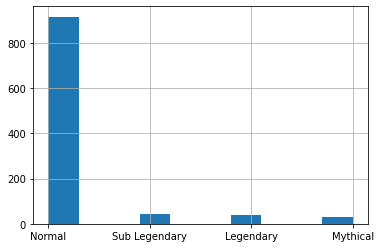

In [36]:
df_raw["status"].hist()

<AxesSubplot:>

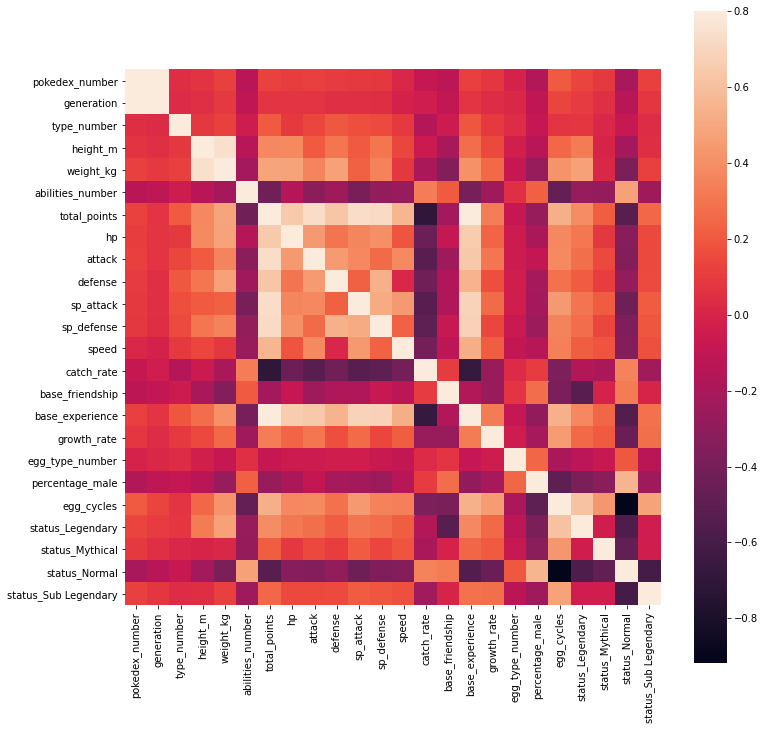

In [37]:
corrmat = pd.concat([df_enc.iloc[:, :21], df_enc[[c for c in df_enc.columns if "status" in c]], df_raw["status"]], axis=1).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=0.8, square=True)

We pick a few notable columns that seem to have a high correlation with the statuses.

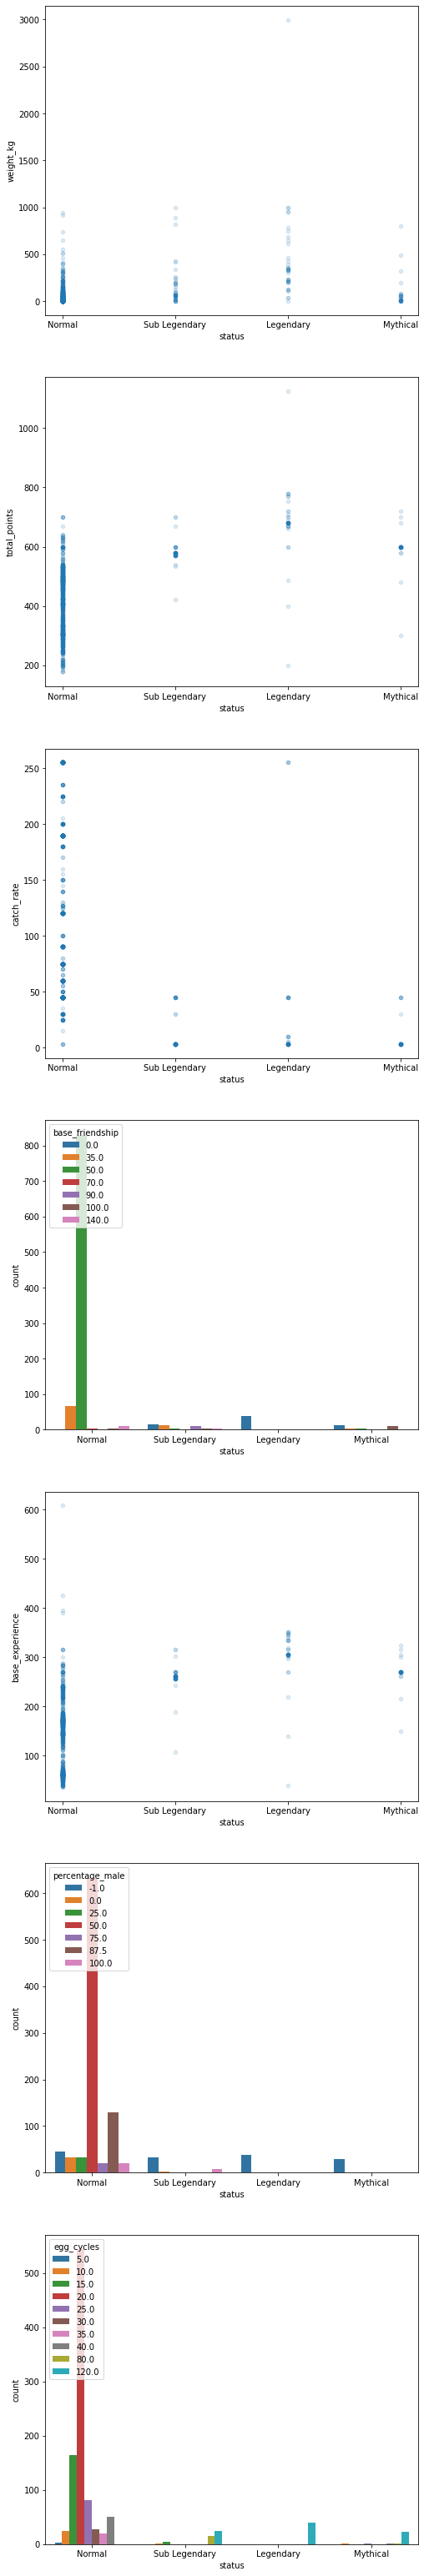

In [38]:
cols = ["weight_kg", "total_points", "catch_rate", "base_friendship", "base_experience", "percentage_male", "egg_cycles"]
fig, axes = plt.subplots(len(cols), 1, figsize=(8, 8 * len(cols)))
for i, col in enumerate(cols):
    if df_raw[col].nunique() > 20:
        df_raw.plot.scatter(x="status", y=col, alpha=0.15, ax=axes.flatten()[i])
    else:
        sns.countplot(data=df_raw.fillna(-1), x="status", hue=col, ax=axes.flatten()[i])


We can see that some fields show clear relationships with statuses. For instance, there are no "normal" pokemon with egg_cycles < 120. It looks like making a distinction between normal / not normal will be simple, but the classification between mythical, legendary, or sublegendary looks a lot more blurry. 

<AxesSubplot:xlabel='generation', ylabel='count'>

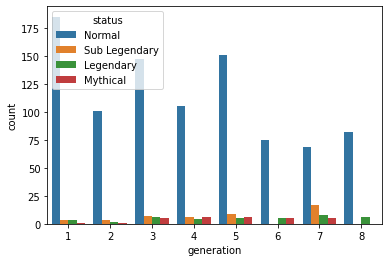

In [39]:
sns.countplot(data=df_raw, x="generation", hue="status")

#### Combat Stats
Many of the above seem like dead giveaways for a model to predict, since non-normal pokemon are usually genderless, unfriendly, and have very low catch rates. Combat stats might be an interesting thing to investigate. 

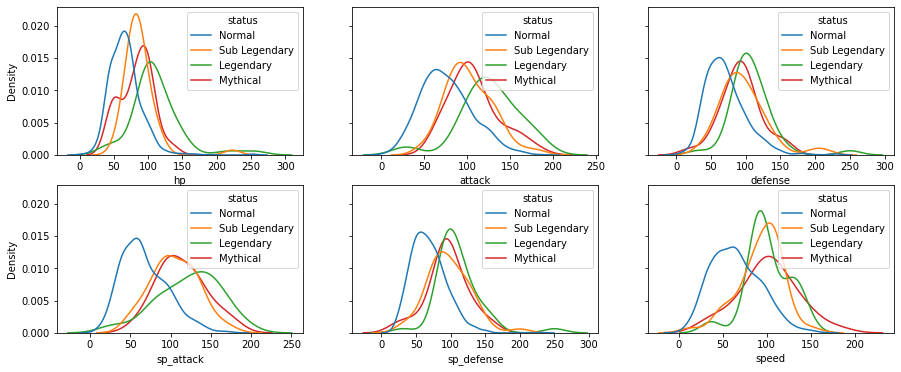

In [40]:
cbt_stats = ["hp", "attack", "defense", "sp_attack", "sp_defense", "speed"]
fig, axes = plt.subplots(len(cbt_stats) // 3, 3, figsize=(15, 1 * len(cbt_stats)), sharey=True)
for i, col in enumerate(cbt_stats):
    sns.kdeplot(data=df_raw, x=col, hue="status", common_norm=False, ax=axes.flatten()[i])

<AxesSubplot:xlabel='total_points', ylabel='Density'>

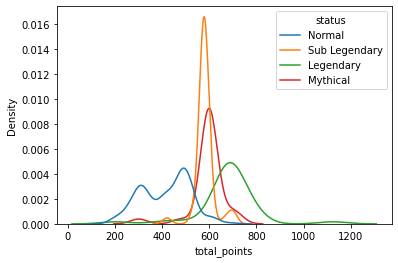

In [41]:
sns.kdeplot(data=df_raw, x="total_points", hue="status", common_norm=False)

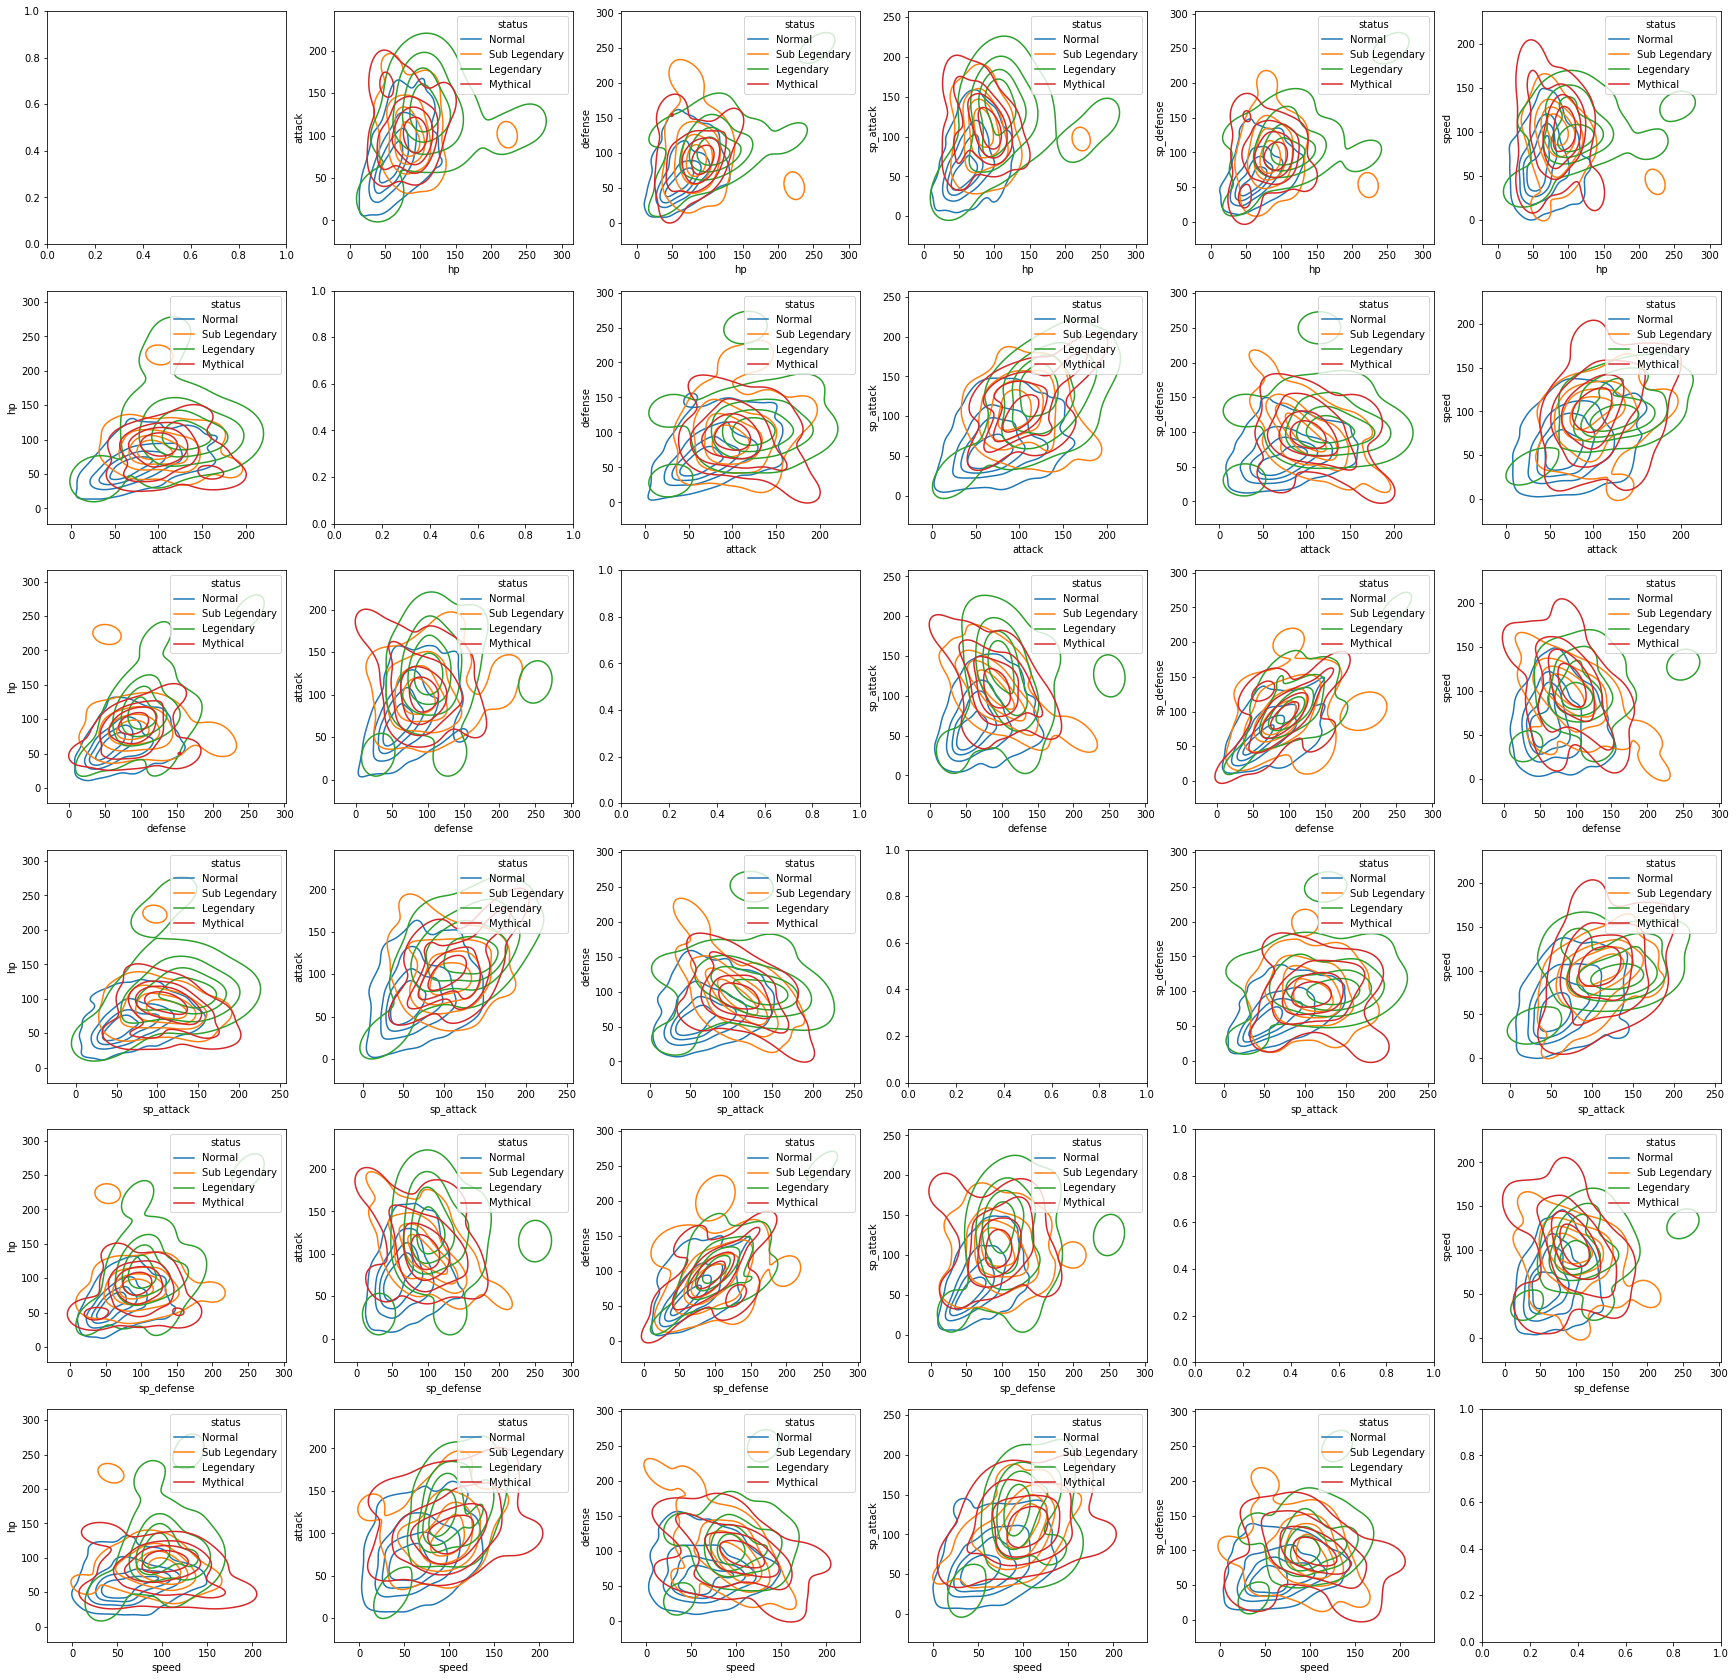

In [42]:
fig, axes = plt.subplots(len(cbt_stats), len(cbt_stats), figsize=(5 * len(cbt_stats), 5 * len(cbt_stats)))
for i in range(len(cbt_stats)):
    for j in range(len(cbt_stats)):
        if i != j:
            sns.kdeplot(data=df_raw, x=cbt_stats[i], y=cbt_stats[j], hue="status", common_norm=False, levels=5, ax=axes[i][j])

Combat stats don't seem to be a very good indicator of status. The most promising areas seem to be total points, attack, sp_attack, sp_attack x hp, and speed x hp. 